In [1]:
#### Restart your kernal and run from here to clear some memory
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
# Check that TF 2.1.0 is in use
print(tf.__version__)

import sys
from os import listdir
from os.path import isfile, join


# run on colab
from google.colab import drive
drive.mount('/content/drive')
datapath = 'drive/My Drive/UCSD/2020/ECE228/PY2/'

2.2.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


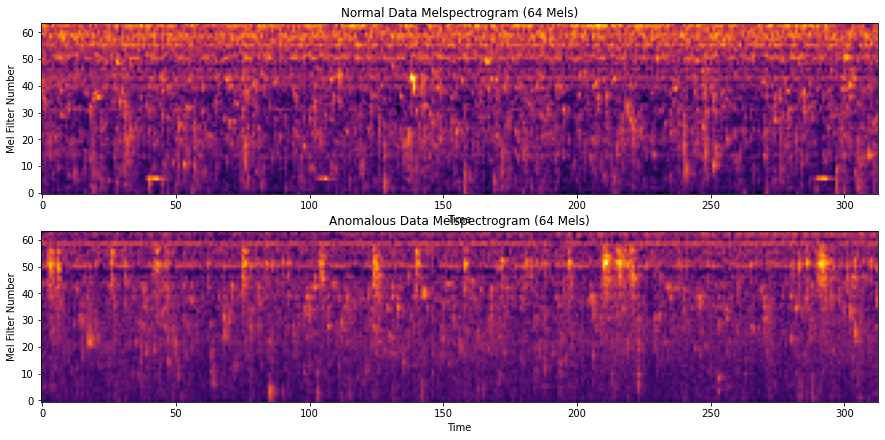

In [2]:
#### Load melspectrograms
ex_norm  = np.load(datapath + 'ex_normalspec.npy')
ex_anom = np.load(datapath + 'ex_abnormspec.npy')
plt.figure(figsize=(15,7))
plt.subplot(211)
plt.imshow(ex_norm[0,::-1], origin='lower', cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Mel Filter Number')
plt.title('Normal Data Melspectrogram (64 Mels)') 

plt.subplot(212)
plt.imshow(ex_anom[0,::-1], origin='lower', cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Mel Filter Number')
plt.title('Anomalous Data Melspectrogram (64 Mels)') 
plt.show()

In [3]:
# Create your own Baseline autoencoder
# Model name is fixed for use by later code
autoencoderBASE = tf.keras.models.Sequential([
    #### Fill in your model #####
    keras.layers.Input(shape=(128,1252, 1)),
#     keras.layers.Flatten(),
#     keras.layers.Dense(4069, activation='relu'),
#     keras.layers.Reshape((64, 64,1)),
    
    keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
    keras.layers.Conv2D(16 , (3, 3), activation='relu',padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
    
    keras.layers.Conv2D(16 , (3, 3), activation='relu',padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(32 , (3, 3), activation='relu',padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    
    keras.layers.Conv2D(1 , (3, 3), activation='relu',padding='same'),
    
])
print(autoencoderBASE .summary())

print('###############################')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 1252, 32)     320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 626, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 626, 16)       4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 313, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 313, 16)       2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 626, 16)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 626, 32)       4

In [4]:
# Load data
x_train = np.load(datapath + 'training_data.npy')
test = np.load(datapath + 'test_data.npy')
print(x_train.shape)
print(test.shape)

# reshape
normaldata_reshape = x_train.reshape(x_train.shape[0],2*64,4*313,1)
test_reshape = test.reshape(test.shape[0],2*64,4*313,1)
print(normaldata_reshape.shape)
print(test_reshape.shape)

x_train_reshape = normaldata_reshape[:800,:,:,:]
x_val_reshape = normaldata_reshape[800:,:,:,:]

(1000, 8, 64, 313)
(143, 8, 64, 313)
(1000, 128, 1252, 1)
(143, 128, 1252, 1)


In [5]:
#test
autoencoderBASE.compile(loss='MSE', optimizer='adam')
history_conv_BASE = autoencoderBASE.fit(x_train_reshape, x_train_reshape, validation_data=(x_val_reshape, x_val_reshape), epochs=100, batch_size=50, shuffle=True)
decoded_data = autoencoderBASE.predict(test_reshape)

Epoch 1/100
16/16 [==============================] - 457s 29s/step - loss: 26.6007 - val_loss: 16.8778
Epoch 2/100
16/16 [==============================] - 447s 28s/step - loss: 16.2759 - val_loss: 14.2545
Epoch 3/100
16/16 [==============================] - 443s 28s/step - loss: 14.0669 - val_loss: 13.3086
Epoch 4/100
16/16 [==============================] - 443s 28s/step - loss: 12.9336 - val_loss: 12.6488
Epoch 5/100
16/16 [==============================] - 441s 28s/step - loss: 12.4021 - val_loss: 12.2445
Epoch 6/100
16/16 [==============================] - 441s 28s/step - loss: 11.9240 - val_loss: 11.8530
Epoch 7/100
16/16 [==============================] - 443s 28s/step - loss: 11.5314 - val_loss: 11.4709
Epoch 8/100
16/16 [==============================] - 444s 28s/step - loss: 11.2348 - val_loss: 11.1809
Epoch 9/100
16/16 [==============================] - 446s 28s/step - loss: 11.0212 - val_loss: 10.9767
Epoch 10/100
16/16 [==============================] - 444s 28s/step - los

Text(0, 0.5, 'loss')

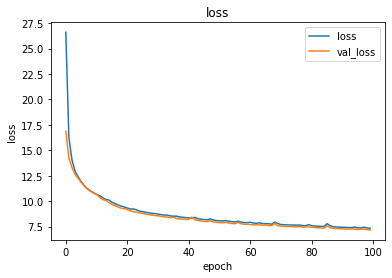

In [6]:
# save the model
autoencoderBASE.save('autoencoderBASE.h5')

# show the training process
#Plot loss vs epoch
plt.plot(history_conv_BASE.history['loss'],label='loss')
plt.plot(history_conv_BASE.history['val_loss'],label='val_loss')
plt.legend(loc='upper right')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')

In [7]:
# def lossFunction(y_true,y_pred):
#   loss = keras.losses.mean_squared_error(y_true,y_pred)
#   return loss

lossFunction = tf.keras.losses.MeanSquaredError()

norm_list = []
dataset = (tf.data.Dataset.from_tensor_slices(normaldata_reshape)).batch(1)
for i, instance in dataset.enumerate():
  ae_predictions = autoencoderBASE(instance).numpy()
  norm_list.append(lossFunction(instance, ae_predictions).numpy())

# Feed the anomaly data through to get its error
anom_list = []
anomset = (tf.data.Dataset.from_tensor_slices(test_reshape)).batch(1)
for i, instance in anomset.enumerate():
  ae_predictions = autoencoderBASE(instance).numpy()
  loss = lossFunction(instance, ae_predictions).numpy()
  anom_list.append(loss)

normal_data_ERRORs = np.array(norm_list)
abnormal_data_ERRORs = np.array(anom_list)
print(normal_data_ERRORs.shape)
print(abnormal_data_ERRORs.shape)

(1000,)
(143,)


The mean of normal data is 7.2899        and standard deviation is 0.6488


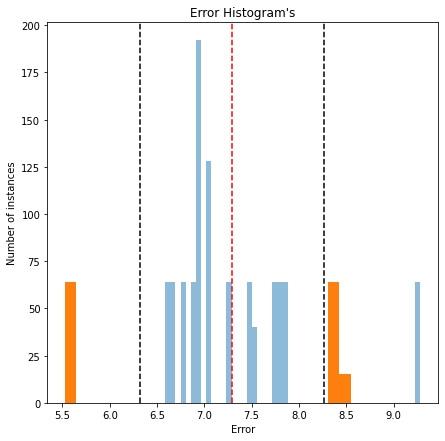

In [14]:

######################### Code for presenting true positives to Question 2.3 ################## 
threshold = 1.5  #2
mean = normal_data_ERRORs.mean()
std = normal_data_ERRORs.std()
print(f'The mean of normal data is {mean:.4f}\
        and standard deviation is {std:.4f}')
upperbound = mean+threshold*std
lowerbound = mean-threshold*std
plt.figure(figsize=(7,7))
plt.title('Error Histogram\'s')
plt.hist(normal_data_ERRORs, bins=50, alpha=0.5)
plt.hist(abnormal_data_ERRORs, bins=25, alpha=1.0)
plt.axvline(mean,ls='--', c='r')
plt.axvline(lowerbound, ls='--',c='k')
plt.axvline(upperbound, ls='--',c='k')
plt.xlabel('Error')
plt.ylabel('Number of instances')
plt.show()

In [12]:
tp_count = np.sum(abnormal_data_ERRORs >= upperbound) +\
           np.sum(abnormal_data_ERRORs <= lowerbound)      
#fn_count = anomaly_data.shape[0] - tp_count
fn_count = 143 - tp_count
fp_count = np.sum(normal_data_ERRORs >= upperbound)+\
           np.sum(normal_data_ERRORs <= lowerbound)        
tn_count = 1000 - fp_count

print(f'TP {tp_count} \t FP {fp_count}')
print(f'FN {fn_count} \t TN {tn_count}')

TP 143 	 FP 128
FN 0 	 TN 872
